In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import sklearn
from sklearn import tree
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample, shuffle

from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

In [2]:
data = pd.read_csv("data_prep.csv", index_col = "ID")

In [63]:
#Splitting the dataset into a training set and testing set
X = data.drop("def_pay", axis=1)
y = data["def_pay"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y, random_state = 41)

X_train.shape, X_test.shape

((21000, 33), (9000, 33))

## Logistic Regression with oversample

In [71]:

# concatenate our training data back together
train = pd.concat([X_train, y_train], axis = 1)

# separate minority and majority classes
not_default =train[train.def_pay == 0]
default = train[train.def_pay == 1]

# upsample minority
default_upsampled = resample(default,
                          replace = True, # sample with replacement
                          n_samples = len(not_default), # match number in majority class
                          random_state = 42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_default, default_upsampled])
upsampled = shuffle(upsampled)

# check new class counts
upsampled.def_pay.value_counts()

1    16355
0    16355
Name: def_pay, dtype: int64

In [72]:
y_train_up = upsampled.def_pay
X_train_up = upsampled.drop("def_pay", axis = 1)

In [73]:
#First model :  Logistic regression

parameters = {"C": np.logspace(-3,3,7),
              "penalty":["l1","l2"]}
lr = LogisticRegression(random_state = 18, solver = "liblinear")
logreg_search = GridSearchCV(lr, parameters, cv = 5)

logreg_search.fit(X_train_up, y_train_up)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=18, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [74]:
logreg_search.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [75]:
lr.set_params(**logreg_search.best_params_) #Put the best hyperparameters in our model
lr.fit(X_train_up, y_train_up)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=18, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
Best_LR_upsampled = logreg_search.best_estimator_

In [77]:
joblib.dump(Best_LR_upsampled,'Best_LR_upsampled' )

['Best_LR_upsampled']

In [78]:
Best_LR = joblib.load('Best_LR_upsampled')

In [79]:
ConfMatrix = confusion_matrix(y_test, Best_LR.predict(X_test))

Accuracy :  0.7613333333333333

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      7009
           1       0.47      0.58      0.52      1991

    accuracy                           0.76      9000
   macro avg       0.67      0.70      0.68      9000
weighted avg       0.78      0.76      0.77      9000



Average 5-Fold CV Score: 0.8079 , Standard deviation: 0.0073



AttributeError: 'QuadMesh' object has no property 'size'

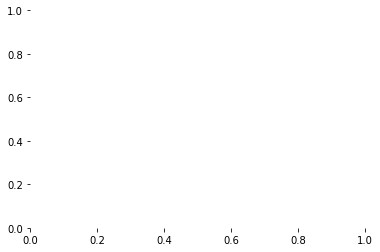

In [93]:
#Model Precision

y_pred = Best_LR.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))
print()
print(classification_report(y_test, y_pred))
print()

## 5-fold cross-validation 
cv_scores = cross_val_score(lr, X, y, cv=5)

print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))
print()


ConfMatrix = confusion_matrix(y_test, Best_LR.predict(X_test))
ax = sns.heatmap(ConfMatrix, annot=True, cmap="Blues", fmt="d",
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])

bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression", size = 14)
plt.show();

## Logistic Regression with undersample

In [81]:
# concatenate our training data back together
train = pd.concat([X_train, y_train], axis = 1)

# separate minority and majority classes
not_default = train[train.def_pay == 0]
default = train[train.def_pay == 1]

# upsample minority
not_default_downsampled = resample(not_default,
                          replace = False, # sample with replacement
                          n_samples = len(default), # match number in majority class
                          random_state = 42) # reproducible results

# combine majority and upsampled minority
downsampled = pd.concat([not_default_downsampled, default])
downsampled = shuffle(downsampled)

# check new class counts
downsampled.def_pay.value_counts()

1    4645
0    4645
Name: def_pay, dtype: int64

In [82]:
y_train_down = downsampled.def_pay
X_train_down = downsampled.drop("def_pay", axis = 1)

In [83]:
#First model :  Logistic regression

parameters = {"C": np.logspace(-3,3,7),
              "penalty":["l1","l2"]}
lr = LogisticRegression(random_state = 18, solver = "liblinear")
logreg_search = GridSearchCV(lr, parameters, cv = 5)

logreg_search.fit(X_train_down, y_train_down)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=18, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [84]:
logreg_search.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [85]:
lr.set_params(**logreg_search.best_params_) #Put the best hyperparameters in our model
lr.fit(X_train_down, y_train_down)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=18, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
Best_LR_downsampled = logreg_search.best_estimator_

In [87]:
joblib.dump(Best_LR_downsampled,'Best_LR_downsampled' )

['Best_LR_downsampled']

In [88]:
Best_LR = joblib.load('Best_LR_downsampled')

In [89]:
ConfMatrix = confusion_matrix(y_test, Best_LR.predict(X_test))

Accuracy :  0.7613333333333333

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      7009
           1       0.47      0.58      0.52      1991

    accuracy                           0.76      9000
   macro avg       0.67      0.70      0.68      9000
weighted avg       0.78      0.76      0.77      9000



Average 5-Fold CV Score: 0.8079 , Standard deviation: 0.0073



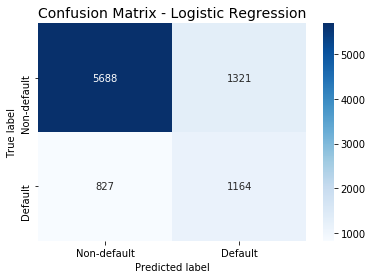

In [91]:
#Model Precision

y_pred = Best_LR.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))
print()
print(classification_report(y_test, y_pred))
print()

## 5-fold cross-validation 
cv_scores = cross_val_score(lr, X, y, cv=5)

print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))
print()


ConfMatrix = confusion_matrix(y_test, Best_LR.predict(X_test))
ax = sns.heatmap(ConfMatrix, annot=True, cmap="Blues", fmt="d",
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])

bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression", size = 14)
plt.show();

## Logistic Regression with SMOTE

In [96]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
X = data.drop("def_pay", axis=1)
y = data["def_pay"]

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y, random_state = 42)

sm = SMOTE(random_state = 42, ratio = 1.0)

X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [97]:
#First model :  Logistic regression

parameters = {"C": np.logspace(-3,3,7),
              "penalty":["l1","l2"]}
lr = LogisticRegression(random_state = 18, solver = "liblinear")
logreg_search = GridSearchCV(lr, parameters, cv = 5)

logreg_search.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=18, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [98]:
Best_LR_sm = logreg_search.best_estimator_

In [99]:
ConfMatrix = confusion_matrix(y_test, Best_LR_sm.predict(X_test))

Accuracy :  0.7606666666666667

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      7009
           1       0.47      0.58      0.52      1991

    accuracy                           0.76      9000
   macro avg       0.67      0.70      0.68      9000
weighted avg       0.78      0.76      0.77      9000



Average 5-Fold CV Score: 0.7801 , Standard deviation: 0.0003



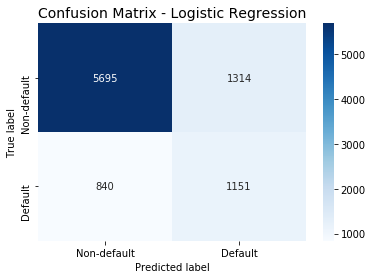

In [100]:
#Model Precision

y_pred = Best_LR.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))
print()
print(classification_report(y_test, y_pred))
print()

## 5-fold cross-validation 
cv_scores = cross_val_score(lr, X, y, cv=5)

print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))
print()


ConfMatrix = confusion_matrix(y_test, Best_LR.predict(X_test))
ax = sns.heatmap(ConfMatrix, annot=True, cmap="Blues", fmt="d",
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])

bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression", size = 14)
plt.show();

## Undersample and SMOTE

In [102]:
# Separate input features and target
X = data.drop("def_pay", axis=1)
y = data["def_pay"]

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y, random_state = 42)

In [109]:
# concatenate our training data back together
train = pd.concat([X_train, y_train], axis = 1)

# separate minority and majority classes
not_default = train[train.def_pay == 0]
default = train[train.def_pay == 1]

# upsample minority
not_default_downsampled = resample(not_default,
                          replace = False, # sample with replacement
                          n_samples = len(default) * 3, # match number in majority class
                          random_state = 42) # reproducible results

# combine majority and upsampled minority
downsampled = pd.concat([not_default_downsampled, default])
downsampled = shuffle(downsampled)

# check new class counts
downsampled.def_pay.value_counts()

0    13935
1     4645
Name: def_pay, dtype: int64

In [110]:
# Separate input features and target
X_train = downsampled.drop("def_pay", axis=1)
y_train = downsampled["def_pay"]

sm = SMOTE(random_state = 42, ratio = 1.0)

X_train_us, y_train_us = sm.fit_sample(X_train, y_train)

In [111]:
#First model :  Logistic regression

parameters = {"C": np.logspace(-3,3,7),
              "penalty":["l1","l2"]}
lr = LogisticRegression(random_state = 18, solver = "liblinear")
logreg_search = GridSearchCV(lr, parameters, cv = 5)

logreg_search.fit(X_train_us, y_train_us)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=18, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [112]:
Best_LR_us = logreg_search.best_estimator_

In [113]:
ConfMatrix = confusion_matrix(y_test, Best_LR_us.predict(X_test))

Accuracy :  0.7606666666666667

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      7009
           1       0.47      0.58      0.52      1991

    accuracy                           0.76      9000
   macro avg       0.67      0.70      0.68      9000
weighted avg       0.78      0.76      0.77      9000



Average 5-Fold CV Score: 0.7801 , Standard deviation: 0.0003



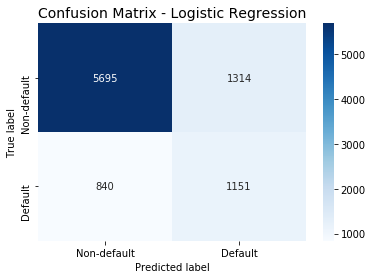

In [114]:
#Model Precision

y_pred = Best_LR.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))
print()
print(classification_report(y_test, y_pred))
print()

## 5-fold cross-validation 
cv_scores = cross_val_score(lr, X, y, cv=5)

print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))
print()


ConfMatrix = confusion_matrix(y_test, Best_LR.predict(X_test))
ax = sns.heatmap(ConfMatrix, annot=True, cmap="Blues", fmt="d",
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])

bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression", size = 14)
plt.show();